In [7]:
#Defining the Bot class
#And also loading required stuff
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
import pandas as pd
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import random
import pyperclip
import numpy as np
from functools import reduce
import math
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.common.exceptions import StaleElementReferenceException

class Dovin:
    def __init__(self, set, format = "PremierDraft", users = "All Users", color = "All", decks = "All", rarity = "All", dates = "All"):
        #Figure out how to do dates eventually
        self.set = set
        self.format = format
        self.users = users
        self.color = color
        self.decks = decks
        self.rarity = rarity
        self.dates = dates
        self.pool = []

    def access_table(self): #Changing to use copy to clipboard option instead
        driver = webdriver.Chrome()
        url = f"https://www.17lands.com/card_data?expansion={self.set}&view=table"
        driver.get(url)
        time.sleep(5)
        if self.format != "PremierDraft":
            format_menu = driver.find_element(By.CSS_SELECTOR, '#format')
            select_format = Select(format_menu)
            select_format.select_by_value(self.format)
            time.sleep(5)
        #Repeat for other options, too lazy to do now
        dropdown = driver.find_element(By.CSS_SELECTOR, '.ui.dropdown')
        dropdown.click()
        time.sleep(5)
        copy_option = driver.find_element(By.XPATH, "//div[@class='item' and contains(text(), 'Copy to clipboard')]")
        copy_option.click()
        time.sleep(3)
        data = pyperclip.paste()
        data_name = f"{self.set}_full_data.txt"
        with open(data_name, "w") as f:
            f.write(data)
        self.data = pd.read_csv(data_name, sep = "\t")
        #Some cleaning stuff
        gih_wr = self.data['GIH WR']
        self.data['GIH WR'] = pd.to_numeric(gih_wr.str.replace('%', ''), errors = 'coerce')
        driver.quit()
        return self.data

    def collect_data(self): #New method, gonna basically replace previous method that would just get original data
        options = webdriver.ChromeOptions()
        #options.add_argument("--headless")
        #options.add_argument("--disable-gpu") #Hopefully these work??
        driver = webdriver.Chrome(options)
        url = f"https://www.17lands.com/card_data?expansion={self.set}&view=table"
        driver.get(url)
        WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".ui.dropdown")))
        if self.format != "PremierDraft": #Not going to do for other options rn
            #MAYBE do for user type, but besides that isn't necessary
            format_menu = driver.find_element(By.CSS_SELECTOR, '#format')
            select_format = Select(format_menu)
            select_format.select_by_value(self.format)
        #Now doing the original data
        dropdown = driver.find_element(By.CSS_SELECTOR, '.ui.dropdown')
        dropdown.click()
        WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.XPATH, "//div[@class='item' and contains(text(), 'Copy to clipboard')]")))
        copy_option = driver.find_element(By.XPATH, "//div[@class='item' and contains(text(), 'Copy to clipboard')]")
        copy_option.click()
        time.sleep(0.3)
        data = pyperclip.paste()
        data_name = f"{self.set}_full_data.txt"
        with open(data_name, "w") as f:
            f.write(data)
        data_master = pd.read_csv(data_name, sep = "\t")
        gih_wr = data_master['GIH WR']
        data_master['GIH WR'] = pd.to_numeric(gih_wr.str.replace('%', ''), errors = 'coerce')
        full_data = data_master[["Name", "Color", "Rarity", "ALSA", "ATA", "GIH WR"]].fillna(0) #Columns I think I'll need, adjust if needed
        self.data = full_data #To ensure it should still work with everything written so far
        time.sleep(0.3) #Arbitrary time

        #Now doing each color and color pair
        color_data = {} #Making a dict, just to make sure this works and then will edit later
        
        deck_menu = driver.find_element(By.CSS_SELECTOR, '#deck_color')
        select_deck = Select(deck_menu)
        color_options = select_deck.options
        for color in color_options:
            color_text = color.text
            if len(color_text) != 2: #Will ignore 1 or 3+ color decks for now
                continue

            deck_menu = driver.find_element(By.CSS_SELECTOR, '#deck_color') #Redefining so it won't be stale
            select_deck = Select(deck_menu)
            select_deck.select_by_value(color_text)
            WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".ui.dropdown")))
            dropdown = driver.find_element(By.CSS_SELECTOR, '.ui.dropdown') #This all basically copy pasted from above
            dropdown.click()
            WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.XPATH, "//div[@class='item' and contains(text(), 'Copy to clipboard')]")))
            copy_option = driver.find_element(By.XPATH, "//div[@class='item' and contains(text(), 'Copy to clipboard')]")
            copy_option.click()
            time.sleep(0.3)
            data = pyperclip.paste()
            data_name = f"{self.set}_{color_text}_data.txt"
            with open(data_name, "w") as f:
                f.write(data)
            data_color = pd.read_csv(data_name, sep = "\t")
            gih_wr = data_color['GIH WR']
            data_color['GIH WR'] = pd.to_numeric(gih_wr.astype(str).str.replace('%', ''), errors = 'coerce')
            data_color = data_color[["Name", "Color", "Rarity", "ALSA", "ATA", "GIH WR"]].fillna(0)
            color_data[color_text] = data_color
            time.sleep(0.3)

        #Now at the end just put it into an attribute
        self.color_data = color_data
        driver.quit()

        #Ok now trying to add the columns for other colors
        #Oh wait this lowkey easy
        for c in color_data.keys():
            c_wr = color_data[c]['GIH WR']
            full_data = pd.concat([full_data, c_wr], axis = 1)
            col_names = full_data.columns.tolist()
            col_names[len(col_names) - 1] = f"{c} WR"
            full_data.columns = col_names

        self.data = full_data
        return self.data
        

    def make_pick(self, pack): #NEEDS FIXING!!!
        #For use in draft simulation
        color_opts = ['W', 'U', 'B', 'R', 'G', 'WU', 'WB', 'WR', 'WG', 'UB', 'UR', 'UG', 'BR', 'BG', 'RG']
        pool = self.pool
        j = len(pool)

        loss_values = []
        for x in pack:
            x_data = self.data[self.data['Name'] == x]
            x_loss = []
            x_color = x_data['Color'].item()
            if len(x_color) == 1: #Card is monocolored
                x_color_pool = pool[pool['Color'] == x_color, ]
                x_color_loss = 1/(len(x_color_pool) + 1) * (x_color_pool['GIH WR'].sum() + x_data['GIH WR'].item())
                omega = np.linalg.norm([j, len(x_color_pool) + 1])
                x_loss.append(x_color_loss-omega)
            print([color for color in colors if len(color) == 2 and x_color in colors])
            for c in [color for color in colors if len(color) == 2 and x_color in colors]:
                color_pool = pool_data[pool_data['Color'] == c]
                x_c_loss = 1/(len(x_color_pool) + len(color_pool) + 1) * (x_color_pool['GIH WR'].sum() + color_pool['GIH WR'].sum() + x_data['GIH WR'].item())
                omega = np.linalg.norm(j - (len(x_color_pool) + len(color_pool) + 1))
                x_loss.append(x_c_loss - omega)
            loss_values.append(max(x_loss))

        #Now find card with max loss and choose that
        card_index = loss_values.index(max(loss_values))
        return pack[card_index]

    def simulate_draft(self): #Switching to 17lands mock drafts!!!
        options = webdriver.ChromeOptions()
        #options.add_argument("--headless")
        options.add_argument("--disable-gpu")
        options.add_argument("--blink-settings=imagesEnabled=false")
        driver = webdriver.Chrome(options=options)
        url = "https://www.17lands.com/mock_draft"
        driver.get(url)

        #Now to change to specific set
        set_menu = driver.find_element(By.CSS_SELECTOR, '#expansion')
        select_set = Select(set_menu)
        select_set.select_by_value(self.set)
        start_button = driver.find_element(By.CSS_SELECTOR, '.btn-light')
        start_button.click()
        time.sleep(5)
        return #Just testing this part for now
        #Manually coding how many picks for now
        #CHANGE IF EVER NEED TO
        pool = []
        pool_color = []
        pool_wr = []

        #try:
        #    ad_popup = driver.find_element(By.CSS_SELECTOR, "#adthrive-sticky-outstream-close")
        #    ad_popup.click()
        #except NoSuchElementException:
        #    print("No ad here")
        
        for _ in range(42): #EDIT THIS!!!
            WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CLASS_NAME, "card")))
            cards = driver.find_elements(By.CLASS_NAME, "card")     
            card_options = []
            for card in cards:
                card_name = card.get_attribute("alt")
                if card_name in ['Plains', 'Island', 'Swamp', 'Mountain', 'Forest', 'Wastes']:
                    #Attempting to fix, just kinda doing it manually so it's only ever the last pick bc yeah
                    continue #Fix for now so it doesn't get stuck on basic lands, not on 17lands which makes sense
                card_options.append(card_name)
            #pool.append(random.choice(card_options)) #Making a random selection for now, will be actual pick later
            #Code would look something like this:
            if len(card_options) == 0:
                for card in cards:
                    print(card.get_attribute("alt"))
                    card.click()
                continue
            print(card_options)
            pick = self.make_pick(card_options)
            print(pick)
            pool.append(pick) #Didn't even change lol
            #Need to figure out clicking lmaooo
            cards = driver.find_elements(By.CLASS_NAME, "card")
            # Wait a moment just to ensure no DOM shift is in progress
            time.sleep(0.5)
        
            # Refetch elements to avoid stale reference
            cards = WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CLASS_NAME, "card"))
            )
        
            clicked = False
            for card in cards:
                try:
                    if card.get_attribute("alt") == pick:
                        #Using this to add color and GIH WR to save to pool for ease of access
                        pool_color.append(self.data[self.data['Name'] == card.get_attribute("alt")]['Color'].item())
                        pool_wr.append(self.data[self.data['Name'] == card.get_attribute("alt")]['GIH WR'].item())
                        card.click()
                        clicked = True
                        pool_df = pd.DataFrame({"Name": pool, "Color": pool_color, "WR": pool_wr})
                        self.pool = pool_df
                        break
                except ElementClickInterceptedException:
                    #Try to scroll to the element, seeing if this works
                    driver.execute_script("arguments[0].scrollIntoView();", card)
                    time.sleep(0.5)
                    card.click() #Hopefully this works
                except StaleElementReferenceException:
                    #Don't do anything, think this is just if it's already passed the card picked
                    continue

        pool_df = pd.DataFrame({"Name": pool, "Color": pool_color, "WR": pool_wr})
        self.pool = pool_df
        driver.quit() #oopsies, forgot this lol
        return self.pool

    def make_deck(self, size = 23, mox = False, username = None, password = None):
        #Work on later
        colors = ['W', 'U', 'B', 'R', 'G']
        color_combo_avgs = {}
        color_combo_card_list = {}
        for color in colors:
            #Now another for loop to get each color combination
            c1_len = len(self.pool[self.pool['Color'] == color])
            if c1_len < 3: #arbitrary number lol
                continue
            for c2 in [c for c in colors if c != color]: #Rn won't be making mono-colored nor triple colored, and will repeat
                #For some of the color combos but based on how I'll set it up it'll work, just take a little more computing
                #than is necessary
                c2_len = len(self.pool[self.pool['Color'] == color])
                if c2_len < 5 or c1_len + c2_len < 23: #If there aren't enough playables of those colors
                    continue
                #Rn only figuring out for monocolored cards, eventually need to figure out dual/more colored
                color_pool = pd.concat([self.pool[self.pool['Color'] == color], self.pool[self.pool['Color'] == c2]]) #Gave up on filtering lol
                top_cards = color_pool.sort_values(by = "WR", ascending = False).iloc[0:23]
                color_combo_avgs[f"{color}{c2}"] = top_cards["WR"].mean()
                color_combo_card_list[f"{color}{c2}"] = top_cards["Name"].tolist()
        opt_color_combo = max(color_combo_avgs, key = color_combo_avgs.get)
        deck_v1 = color_combo_card_list[opt_color_combo]
        deck = []
        for card in set(deck_v1):
            number_of = len([c for c in deck_v1 if c == card])
            deck.append(f"{number_of} {card}")
        self.deck = deck

        if mox: #Figure out moxfield stuff later!!!
            print("Yippee")
        
        return self.deck

In [8]:
#Now trying for an easier set

#test_DFT = Dovin("DFT")
#test_DFT.collect_data()
print(test_DFT.simulate_draft())
#test_DFT.make_deck()

['Gonti, Night Minister', 'Thundering Broodwagon', 'Rise from the Wreck', 'Shefet Archfiend', 'Embalmed Ascendant', 'Burner Rocket', 'Walking Sarcophagus', 'Flood the Engine', 'Engine Rat', 'Alacrian Jaguar', 'Lotusguard Disciple', 'Lightning Strike', 'Jungle Hollow', 'Prowcatcher Specialist']


TypeError: list indices must be integers or slices, not str

In [20]:
print(test_DFT.simulate_draft())
test_DFT.make_deck()

['Explosive Getaway', 'Tyrox, Saurid Tyrant', 'Elvish Refueler', 'Cloudspire Skycycle', 'Boosted Sloop', 'Endrider Catalyzer', 'Gastal Blockbuster', 'Gearseeker Serpent', 'Brightfield Mustang', 'Deathless Pilot', 'Veloheart Bike', 'Alacrian Jaguar', 'Cloudspire Skycycle']
Explosive Getaway
['Transit Mage', 'Memory Guardian', "Racers' Scoreboard", 'Streaking Oilgorger', 'Broadcast Rambler', 'Kickoff Celebrations', 'Gearseeker Serpent', 'Migrating Ketradon', 'Jibbirik Omnivore', 'Deathless Pilot', 'Risky Shortcut', 'Thornwood Falls', 'Trip Up']
Transit Mage
['Intimidation Tactics', 'Spire Mechcycle', 'Thundering Broodwagon', 'Memory Guardian', 'Silken Strength', 'Clamorous Ironclad', 'Nimble Thopterist', 'Daring Mechanic', 'Pactdoll Terror', 'Grim Javelineer', 'Streaking Oilgorger']
Thundering Broodwagon
['Country Roads', 'Shefet Archfiend', 'Hour of Victory', 'Glitch Ghost Surveyor', 'Daring Mechanic', 'Broken Wings', 'Deathless Pilot', 'Magmakin Artillerist', 'Chitin Gravestalker', 'Ju

['1 Veloheart Bike',
 '1 Elvish Refueler',
 '1 Migrating Ketradon',
 '1 Stock Up',
 '3 Stampeding Scurryfoot',
 '2 Hazard of the Dunes',
 '1 Bestow Greatness',
 '1 Terrian, World Tyrant',
 '1 Venomsac Lagac',
 '2 Bounce Off',
 '3 Beastrider Vanguard',
 '1 Transit Mage',
 '3 Pothole Mole',
 '1 Molt Tender',
 '1 Run Over']

In [140]:
test_FIN = Dovin("FIN")
FIN_data = test_FIN.access_table()
FIN_data

python(56642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
0,Summon: Bahamut,NaN,M,6351,1.43,4199,1.41,22485,89.0%,54.3%,3726,51.7%,6142,59.8%,9868,56.7,12338,52.0%,4.7pp
1,"Ultima, Origin of Oblivion",NaN,R,22451,2.43,5985,2.67,30775,87.0%,52.8%,5052,50.9%,8020,54.4%,13072,53.1,17550,52.4%,0.7pp
2,Adelbert Steiner,W,U,84221,3.31,22075,3.92,119800,87.6%,57.1%,21560,58.3%,27655,57.7%,49215,58.0,70430,56.4%,1.6pp
3,Aerith Gainsborough,W,R,21605,2.36,6482,2.56,32131,82.9%,54.6%,5644,55.7%,7798,54.8%,13442,55.2,18644,54.2%,1.0pp
4,Aerith Rescue Mission,W,C,411698,6.88,50672,9.88,106173,34.5%,54.6%,17712,51.5%,24505,55.5%,42217,53.8,63711,55.1%,-1.2pp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,"Yuriko, the Tiger's Shadow",UB,R,5011,4.00,1008,5.04,3225,53.8%,51.3%,551,49.0%,928,55.1%,1479,52.8,1712,50.2%,2.6pp
353,Chromatic Lantern,NaN,R,5541,4.20,670,5.90,1868,48.3%,49.1%,358,NaN,467,NaN,825,48.4,1026,49.7%,-1.3pp
354,Smuggler's Copter,NaN,R,1887,1.57,1552,1.60,9800,99.0%,59.6%,1791,66.9%,2399,62.5%,4190,64.4,5191,55.1%,9.3pp
355,Strixhaven Stadium,NaN,U,65869,7.81,6761,11.74,1182,2.9%,47.5%,200,NaN,288,NaN,488,NaN,684,48.2%,NaN


In [145]:
#Draftsim with actual picking mechanism time

test_FIN.simulate_draft() #OOh ok Chat fixed it, still not working but that's a DraftSim issue

python(57183) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


['Starting Town', 'Relentless X-ATM092', 'Garland, Knight of Cornelia', 'Evil Reawakened', 'Barret Wallace', 'Scorpion Sentinel', 'Resentful Revelation', 'Magitek Infantry', 'Item Shopkeep', "Prishe's Wanderings", "Warrior's Sword", 'Deadly Dispute', 'Windurst, Federation Center', 'Omega, Heartless Evolution']
Resentful Revelation
['Swallowed by Leviathan', 'Crystal Fragments', 'Chocobo Racetrack', "Shambling Cie'th", 'White Auracite', "Sage's Nouliths", "Red Mage's Rapier", 'Gran Pulse Ochu', 'Qutrub Forayer', 'Balamb T-Rexaur', 'Wall of Omens', 'Windurst, Federation Center', 'World Map']
White Auracite
['Jumbo Cactuar', 'Ultros, Obnoxious Octopus', 'Sidequest Play Blitzball', 'Goobbue Gardener', 'Malboro', 'Blazing Bomb', 'Syncopate', "Paladin's Arms", 'Namazu Trader', 'Syr Konrad, the Grim', "Joshua, Phoenix's Dominant"]


ValueError: can only convert an array of size 1 to a Python scalar

In [80]:
sample_pack = FIN_data['Name'].sample(n=14, replace = False).tolist()
sample_pool = FIN_data['Name'].sample(n=15, replace = False).tolist()
#test_FIN.access_table()
print(sample_pack)
print(sample_pool)
test_FIN.make_pick(sample_pack, sample_pool)

['Counterspell', 'Ride the Shoopuf', 'Starting Town', 'Kuja, Genome Sorcerer', 'Lion Heart', 'Shantotto, Tactician Magician', 'The Masamune', 'Gongaga, Reactor Town', 'Venser, Shaper Savant', 'Esper Origins', 'Zell Dincht', 'Adelbert Steiner', "Jill, Shiva's Dominant", 'Ashe, Princess of Dalmasca']
['Quina, Qu Gourmet', 'Yawgmoth, Thran Physician', 'Counterspell', 'Zidane, Tantalus Thief', 'Black Waltz No. 3', 'Summon: Bahamut', 'Chromatic Lantern', 'Garnet, Princess of Alexandria', 'Light of Judgment', 'Fire Magic', "Yuriko, the Tiger's Shadow", 'Tonberry', 'Treno, Dark City', 'Nyxbloom Ancient', 'Scorpion Sentinel']


"Jill, Shiva's Dominant"

In [81]:
#Trying to make custom packs/pools to see if it works
test_pack = ['Aerith Gainsborough', 'Adelbert Steiner', 'The Prima Vista', 'Sahagin', 'Demon Wall']
no_pool = []
print(test_FIN.make_pick(test_pack, no_pool))
ur_pool = ['Sahagin', 'Ice Magic', 'Fire Magic', 'Blazing Bomb', "Jill, Shiva's Dominant",
         'Summon: Leviathan', 'The Lunar Whale', 'Thunder Magic', 'Matoya, Archon Elder', 'The Prima Vista', 'Memories Returning',
         'Quistis Trepe']
print(test_FIN.make_pick(test_pack, ur_pool)) #Ohhh ok I see now
#Basically rn, because I messed up and the picks don't count for multiples, I was trying individual names and seeing if like a bunch of 
#blue only cards would force it to pick Sahagin, but, instead, it would keep picking Adelbert, since it was looking at UW and ALL the 
#cards would fit in UW even though all of them were U except Adelbert, so the loss would still be 0
#Gonna try initial draftsim to see how it works, will update code later and do more testing to figure out multiples problem

Adelbert Steiner
Sahagin


In [68]:
#Doing the convolution and probability stuff

import numpy as np
from functools import reduce
import math

#Simple one, from 0 appearance to 12 appearances, won't count land or bonus slot
#so basically max will be 12, min will be 0
#And let's just assume one rare, one mythic per pack even though that's not rally how it works lol

colors = ['W', 'U', 'B', 'R', 'G']
color_probs = {}

def hypergeom_probs(color, rarity, x, y):
    K = len(FIN_data[(color_filter(FIN_data, color)) & (FIN_data['Rarity'] == rarity)]) #Function defined in later chunk
    N = len(FIN_data[FIN_data['Rarity'] == rarity])
    numerator = math.comb(K, x) * math.comb(N-K, y - x)
    return numerator / math.comb(N, y)

#print(hypergeom_probs('W', 'R', 0, 2))
#Test loop

common_white_probs = []
for i in range(7):
    common_white_probs.append(hypergeom_probs('W', 'C', i, 7))

print(common_white_probs)

for color in colors:
    probs = []
    for i in range(3):
        probs.append(hypergeom_probs(color, 'R', i, 3))
    print(f"{color} rare probabilities")
    print(probs)

NameError: name 'color_filter' is not defined

/var/folders/87/h2bv4zts29q6sx_v6nfcv_3w0000gn/T/ipykernel_89572/3083701990.py:15: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  K = len(FIN_data[(color_filter(FIN_data, color)) & (FIN_data['Rarity'] == rarity)]) #Function defined in later chunk


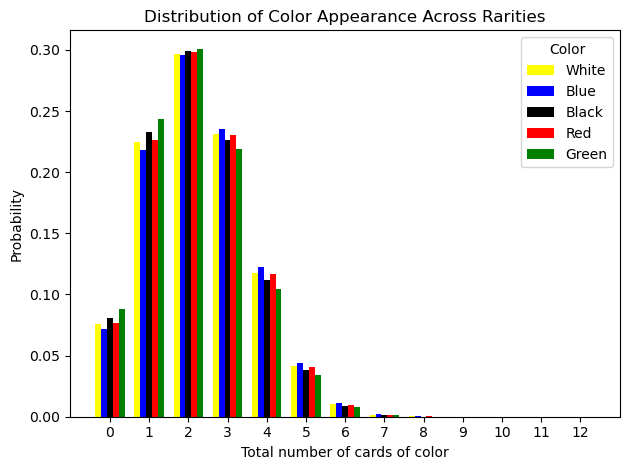

In [7]:
#OK now trying the convolve stuff

import matplotlib.pyplot as plt

colors = ['W', 'U', 'B', 'R', 'G']
color_names = ['White', 'Blue', 'Black', 'Red', 'Green']
bar_width = 0.15
cards = np.arange(13)
color_color = ['yellow', 'blue', 'black', 'red', 'green']

for idx, color in enumerate(colors):   
    mythic_probs = [hypergeom_probs(color, 'M', i, 1) for i in range(2)]
    rare_probs   = [hypergeom_probs(color, 'R', i, 1) for i in range(2)]
    unc_probs    = [hypergeom_probs(color, 'U', i, 3) for i in range(4)]
    com_probs    = [hypergeom_probs(color, 'C', i, 7) for i in range(8)]

    all_probs = [mythic_probs, rare_probs, unc_probs, com_probs]
    total_probs = reduce(np.convolve, all_probs)

    # Shift x-values for this color's bars
    shifted_x = cards + (idx - len(colors)/2) * bar_width + bar_width/2
    plt.bar(shifted_x, total_probs, width=bar_width, label=color_names[idx], color = color_color[idx])

plt.xlabel("Total number of cards of color")
plt.ylabel("Probability")
plt.legend(title="Color")
plt.title("Distribution of Color Appearance Across Rarities")
plt.xticks(cards)
plt.tight_layout()
plt.show()

In [8]:
#Means

def color_filter(data, color):
    filter = []
    for i in range(len(data)):
        clr = str(data[data.index == i]['Color'].item())
        if color in clr:
            filter.append(True)
        else:
            filter.append(False)
    return filter

def hypergeom_mean(color, rarity, y):
    K = len(FIN_data[(color_filter(FIN_data, color)) & (FIN_data['Rarity'] == rarity)])
    N = len(FIN_data[FIN_data['Rarity'] == rarity])
    return y * (K / N)

colors = ['W', 'U', 'B', 'R', 'G']
rarities = ['M', 'R', 'U', 'C']
num_in_rarity = [1, 1, 3, 7]

for color in colors:
    color_mean = 0
    for i in range(4):
        color_mean += hypergeom_mean(color, rarities[i], num_in_rarity[i])
    print(f"{color} mean: {color_mean}")

#color_filter(FIN_data, 'W')

W mean: 2.2626534890685837
U mean: 2.3056903264450437
B mean: 2.2150344414495358
R mean: 2.253578915843067
G mean: 2.1489967056004793


/var/folders/87/h2bv4zts29q6sx_v6nfcv_3w0000gn/T/ipykernel_89572/4062531028.py:14: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  K = len(FIN_data[(color_filter(FIN_data, color)) & (FIN_data['Rarity'] == rarity)])


In [6]:
FIN_prob_open = {}
FIN_color_avgs = {'W': 0, 'U': 0, 'B': 0, 'R': 0, 'G': 0, 'Colorless': 0}
for card in FIN_data['Name']:
    rarity = FIN_data[FIN_data['Name'] == card]['Rarity'].item()
    if rarity == 'M':
        prob = (1/8) * (1/len(FIN_data[FIN_data['Rarity'] == 'M'])) + (2/len(FIN_data))
    if rarity == 'R':
        prob = (7/8) * (1/len(FIN_data[FIN_data['Rarity'] == 'R'])) + (2/len(FIN_data))
    if rarity == 'U':
        total_unc = len(FIN_data[FIN_data['Rarity'] == 'U'])
        prob = (1/total_unc) * (((total_unc - 1) / total_unc) ** 2) + (2/len(FIN_data))
    if rarity == 'C':
        total_com = len(FIN_data[FIN_data['Rarity'] == 'C'])
        prob = (1/total_com) * (((total_com - 1) / total_com) ** 6) + (2/len(FIN_data))
    FIN_prob_open[card] = prob
    #Now for color side
    color = FIN_data[FIN_data['Name'] == card]['Color'].item()
    if pd.isna(color):
        color = 'Colorless'
        FIN_color_avgs['Colorless'] += prob
    if 'W' in color:
        FIN_color_avgs['W'] += prob
    if 'U' in color:
        FIN_color_avgs['U'] += prob
    if 'B' in color:
        FIN_color_avgs['B'] += prob
    if 'R' in color:
        FIN_color_avgs['R'] += prob
    if 'G' in color:
        FIN_color_avgs['G'] += prob
    print(f"{card}: {prob}") #More likely to see any given rare than any given uncommon, very interesting!
print(FIN_color_avgs)

Summon: Bahamut: 0.009173669467787115
Ultima, Origin of Oblivion: 0.013856957877490618
Adelbert Steiner: 0.013413272422431642
Aerith Gainsborough: 0.013856957877490618
Aerith Rescue Mission: 0.015992885095829627
Ambrosia Whiteheart: 0.013413272422431642
Ashe, Princess of Dalmasca: 0.013413272422431642
Auron's Inspiration: 0.013413272422431642
Battle Menu: 0.013413272422431642
Cloud, Midgar Mercenary: 0.009173669467787115
Cloudbound Moogle: 0.015992885095829627
Coeurl: 0.015992885095829627
Crystal Fragments: 0.013413272422431642
The Crystal's Chosen: 0.013413272422431642
Delivery Moogle: 0.013413272422431642
Dion, Bahamut's Dominant: 0.013856957877490618
Dragoon's Lance: 0.013413272422431642
Dwarven Castle Guard: 0.015992885095829627
Fate of the Sun-Cryst: 0.015992885095829627
From Father to Son: 0.013856957877490618
G'raha Tia: 0.013413272422431642
Gaelicat: 0.015992885095829627
Machinist's Arsenal: 0.013856957877490618
Magitek Armor: 0.013413272422431642
Magitek Infantry: 0.0159928850

In [11]:
#Testing the DraftSim stuff so far

test_FIN = Dovin("FIN")
FIN_sim = test_FIN.simulate_draft()
print(FIN_sim)
#OK cool, it works, need to do the math part of stuff now :(

['Jecht, Reluctant Guardian', 'Gysahl Greens', 'Gaelicat', 'Tonberry', 'Valkyrie Aerial Unit', 'Haste Magic', 'Treno, Dark City', 'Valkyrie Aerial Unit', 'Gaelicat', 'Haste Magic', 'Jecht, Reluctant Guardian', 'Garland, Knight of Cornelia', 'Treno, Dark City', 'Gysahl Greens', 'Haste Magic', 'Treno, Dark City', 'Garland, Knight of Cornelia', 'Magitek Infantry', 'Combat Tutorial', 'Gysahl Greens', 'Tonberry', 'Airship Crash', 'Gysahl Greens', "Rydia's Return", 'Gaelicat', 'Tonberry', 'Treno, Dark City', 'Gysahl Greens', 'Gysahl Greens', 'Haste Magic', 'Haste Magic', 'Airship Crash', 'Valkyrie Aerial Unit', 'Airship Crash', 'Airship Crash', "Rydia's Return", 'Garland, Knight of Cornelia', 'Garland, Knight of Cornelia', 'Shinra Reinforcements', 'Shinra Reinforcements', 'Gysahl Greens', 'Valkyrie Aerial Unit']


In [12]:
color_means = {}
total_cards = len(FIN_data)
for color in FIN_data['Color'].unique():
    color_means[f"{color}"] = len(FIN_data[[str(color) in str(card) for card in FIN_data['Color']]]) / total_cards
print(color_means) #Yessss let's go

#Now for sds :0
#Actually the more I think about it the less sense SDs make?

{'nan': 0.13725490196078433, 'W': 0.2184873949579832, 'U': 0.2184873949579832, 'B': 0.21288515406162464, 'R': 0.20728291316526612, 'G': 0.19327731092436976, 'WU': 0.028011204481792718, 'RG': 0.014005602240896359, 'BR': 0.022408963585434174, 'WUG': 0.0028011204481792717, 'BG': 0.01680672268907563, 'UB': 0.03361344537815126, 'UR': 0.014005602240896359, 'WG': 0.011204481792717087, 'WR': 0.01680672268907563, 'UG': 0.01680672268907563, 'WB': 0.014005602240896359, 'UBR': 0.008403361344537815, 'WUB': 0.008403361344537815, 'UBG': 0.008403361344537815, 'WUBRG': 0.0028011204481792717, 'WUBG': 0.0028011204481792717, 'WBR': 0.0028011204481792717}


In [3]:
#Initial scraping, trying to see if it is possible to scrape tables based on specified things so you don't need to provide the dataset

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
import pandas as pd
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pyperclip

driver = webdriver.Chrome()

driver.get("https://www.17lands.com/card_data?expansion=FIN&format=PremierDraft&start=2025-06-10&view=table")

time.sleep(5)

element = driver.find_element(By.CSS_SELECTOR, '.ui.dropdown')

print(element.text)

element.click()

time.sleep(5)

#print(element.get_attribute("outerHTML"))

#csv_option = driver.find_element(By.CSS_SELECTOR, 'div[role="option"] a[download$=".csv"]')

#print(csv_option.text) #Ok cool works

copy_option = driver.find_element(By.XPATH, "//div[@class='item' and contains(text(), 'Copy to clipboard')]") #Ok that works too

print(copy_option.text)

copy_option.click()

time.sleep(3)

data = pyperclip.paste()

print(data)

#time.sleep(20)

driver.quit() #Ok cool it works

Export data
Copy to clipboard
Name	Color	Rarity	# Seen	ALSA	# Picked	ATA	# GP	% GP	GP WR	# OH	OH WR	# GD	GD WR	# GIH	GIH WR	# GNS	GNS WR	IWD
Summon: Bahamut		M	3605	1.40	2487	1.38	13201	88.7%	54.6%	2157	51.7%	3605	59.8%	5762	56.8%	7282	52.6%	4.2pp
Ultima, Origin of Oblivion		R	11758	2.21	3612	2.30	18926	88.8%	53.2%	3100	51.4%	4927	54.7%	8027	53.4%	10819	52.8%	0.7pp
Adelbert Steiner	W	U	47957	3.28	12802	3.83	68778	87.3%	57.1%	12381	58.6%	15919	57.8%	28300	58.1%	40403	56.4%	1.8pp
Aerith Gainsborough	W	R	11829	2.24	3817	2.40	18915	83.3%	54.6%	3368	55.8%	4568	55.3%	7936	55.5%	10953	53.9%	1.6pp
Aerith Rescue Mission	W	C	235699	6.73	29512	9.62	67071	37.7%	54.4%	11195	51.4%	15472	55.6%	26667	53.8%	40279	54.8%	-1.0pp
Ambrosia Whiteheart	W	U	53175	3.52	12799	4.27	68269	87.4%	56.1%	12225	56.4%	15769	56.5%	27994	56.4%	39861	55.8%	0.6pp
Ashe, Princess of Dalmasca	W	U	62112	4.29	10517	5.57	47680	75.4%	55.3%	8531	55.6%	10980	53.8%	19511	54.5%	28104	55.8%	-1.2pp
Auron's Inspiration	W	U	92392	6.97	113

In [7]:
with open("data.txt", "w") as f:
    f.write(data)
data_test = pd.read_csv("data.txt", sep = "\t")
data_test #OK cool this works too

,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
0,Summon: Bahamut,NaN,M,3605,1.40,2487,1.38,13201,88.7%,54.6%,2157,51.7%,3605,59.8%,5762,56.8%,7282,52.6%,4.2pp
1,"Ultima, Origin of Oblivion",NaN,R,11758,2.21,3612,2.30,18926,88.8%,53.2%,3100,51.4%,4927,54.7%,8027,53.4%,10819,52.8%,0.7pp
2,Adelbert Steiner,W,U,47957,3.28,12802,3.83,68778,87.3%,57.1%,12381,58.6%,15919,57.8%,28300,58.1%,40403,56.4%,1.8pp
3,Aerith Gainsborough,W,R,11829,2.24,3817,2.40,18915,83.3%,54.6%,3368,55.8%,4568,55.3%,7936,55.5%,10953,53.9%,1.6pp
4,Aerith Rescue Mission,W,C,235699,6.73,29512,9.62,67071,37.7%,54.4%,11195,51.4%,15472,55.6%,26667,53.8%,40279,54.8%,-1.0pp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,"Yuriko, the Tiger's Shadow",UB,R,2844,3.99,590,4.93,1883,54.2%,51.4%,341,NaN,529,55.4%,870,53.0%,993,50.1%,2.9pp
353,Chromatic Lantern,NaN,R,3109,4.00,389,NaN,1188,53.8%,50.5%,225,NaN,304,NaN,529,50.5%,649,50.4%,0.1pp
354,Smuggler's Copter,NaN,R,1078,1.61,864,1.63,5417,98.5%,59.5%,986,68.5%,1351,62.1%,2337,64.8%,2870,54.7%,10.1pp
355,Strixhaven Stadium,NaN,U,37680,7.59,3738,11.52,851,3.8%,47.8%,144,NaN,206,NaN,350,NaN,496,NaN,NaN


In [16]:
#Chat beefed up version

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

start = time.time()

options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--blink-settings=imagesEnabled=false")

driver = webdriver.Chrome(options=options)
driver.get("https://draftsim.com/draft.php?mode=Draft_FIN")

WebDriverWait(driver, 10).until(
    EC.presence_of_all_elements_located((By.CLASS_NAME, "card"))
)

cards = driver.find_elements(By.CLASS_NAME, "card")

for card in cards:
    print(card.get_attribute("alt"))

driver.quit()

print(f"Scraped in {time.time() - start:.2f} seconds") #Oh damn that was quick

Triple Triad
Cargo Ship
Prompto Argentum
Stolen Uniform
Relm's Sketching
Gaelicat
Iron Giant
Call the Mountain Chocobo
Cornered by Black Mages
Ice Flan
Airship Crash
Fight On!
Sharlayan, Nation of Scholars
Machinist's Arsenal
Scraped in 4.42 seconds


In [13]:
#Now trying out the implementation on Draftsim

driver = webdriver.Chrome()

driver.get("https://draftsim.com/draft.php?mode=Draft_FIN")

time.sleep(5)

cards = driver.find_elements(By.CLASS_NAME, "card")

for card in cards:
    print(card.get_attribute("alt"))

driver.quit()

The Earth Crystal
Sleep Magic
Giott, King of the Dwarves
Reach the Horizon
Garnet, Princess of Alexandria
Gysahl Greens
Hecteyes
Coeurl
Hill Gigas
Ice Flan
Town Greeter
Syr Konrad, the Grim
Wastes
Gaelicat


In [3]:
#Trying it out briefly

test_FIN = Dovin("FIN")
FIN_data = test_FIN.access_table()
FIN_data.head() #Ok it works!

,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
0,Summon: Bahamut,NaN,M,3104,1.39,2164,1.37,11649,88.9%,54.9%,1906,52.0%,3150,60.5%,5056,57.3%,6448,52.8%,4.5pp
1,"Ultima, Origin of Oblivion",NaN,R,9978,2.16,3163,2.23,16669,89.2%,53.3%,2705,51.9%,4339,54.9%,7044,53.8%,9557,52.7%,1.0pp
2,Adelbert Steiner,W,U,41860,3.28,11150,3.83,59899,87.2%,57.3%,10806,58.9%,13839,57.8%,24645,58.3%,35184,56.6%,1.7pp
3,Aerith Gainsborough,W,R,10112,2.20,3369,2.35,16510,83.0%,54.6%,2934,55.9%,4000,55.5%,6934,55.7%,9551,53.9%,1.7pp
4,Aerith Rescue Mission,W,C,204730,6.69,25604,9.55,59303,38.3%,54.6%,9890,51.8%,13707,55.7%,23597,54.1%,35595,55.0%,-0.9pp


In [4]:
FIN_data

,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
0,Summon: Bahamut,NaN,M,3104,1.39,2164,1.37,11649,88.9%,54.9%,1906,52.0%,3150,60.5%,5056,57.3%,6448,52.8%,4.5pp
1,"Ultima, Origin of Oblivion",NaN,R,9978,2.16,3163,2.23,16669,89.2%,53.3%,2705,51.9%,4339,54.9%,7044,53.8%,9557,52.7%,1.0pp
2,Adelbert Steiner,W,U,41860,3.28,11150,3.83,59899,87.2%,57.3%,10806,58.9%,13839,57.8%,24645,58.3%,35184,56.6%,1.7pp
3,Aerith Gainsborough,W,R,10112,2.20,3369,2.35,16510,83.0%,54.6%,2934,55.9%,4000,55.5%,6934,55.7%,9551,53.9%,1.7pp
4,Aerith Rescue Mission,W,C,204730,6.69,25604,9.55,59303,38.3%,54.6%,9890,51.8%,13707,55.7%,23597,54.1%,35595,55.0%,-0.9pp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,"Yuriko, the Tiger's Shadow",UB,R,2478,3.97,525,4.85,1688,54.9%,51.7%,311,NaN,474,NaN,785,53.5%,884,50.0%,3.5pp
353,Chromatic Lantern,NaN,R,2644,3.91,329,NaN,1048,55.7%,50.8%,200,NaN,263,NaN,463,NaN,576,50.5%,NaN
354,Smuggler's Copter,NaN,R,954,1.63,754,1.66,4695,98.4%,59.6%,860,68.3%,1177,63.0%,2037,65.2%,2478,54.3%,10.9pp
355,Strixhaven Stadium,NaN,U,32680,7.52,3215,11.46,779,4.0%,48.8%,130,NaN,189,NaN,319,NaN,455,NaN,NaN


In [5]:
#FIN_data.index(min(FIN_data['GP WR'])) #Ohhhh will need to do some cleaning